In [1]:
import json
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = r"./data/tvtropes_books"

for fname in (f"tvtropes_books-{suffix}.json" for suffix in ["train", "test", "val"]):
    assert (Path(DATA_PATH) / fname).is_file(), f"File {fname} not found"

In [3]:
train_list, val_list, test_list = [], [], []
for path, which in ((Path(DATA_PATH) / f"tvtropes_books-{suffix}.json", suffix) for suffix in ["train", "test", "val"]):
    with open(path, "r") as f:
        for line in f:
            globals()[f"{which}_list"].append(json.loads(line))

In [4]:
len(train_list), len(val_list), len(test_list)

(273262, 34158, 34158)

In [5]:
train_list[0]

{'page': 'https://tvtropes.org/pmwiki/pmwiki.php/Literature/ServantsOfTheEmpire',
 'trope': 'Simultaneous Arcs',
 'has_spoiler': True,
 'sentences': [[False,
   'The series takes place at least a year before Season 1 and after "Fire Across the Galaxy".',
   []],
  [False,
   "As a result, mentions of the Ghost crew's exploits are thrown around every once and a while.",
   []],
  [False, 'We also get some Adaptation Expansion as well. "', []],
  [False, 'Breaking Ranks" gets novelized in "Rebel in the Ranks".', []],
  [False,
   'While on the way to cutting off her debt to the Gray Syndicate during "Imperial Justice", Zeb comms Merei to get information from Zare on the Trayvis situation in "Vision of Hope".',
   []],
  [False,
   'Due to being preoccupied, she rejects it and tells them to send Chopper.',
   []],
  [False,
   "Chopper passes Zare a note from 'Dev', and the meeting scene from the same episode occurs later.",
   []],
  [False,
   'The seizure of the communications tower fr

In [6]:
train_list[0]['sentences']

[[False,
  'The series takes place at least a year before Season 1 and after "Fire Across the Galaxy".',
  []],
 [False,
  "As a result, mentions of the Ghost crew's exploits are thrown around every once and a while.",
  []],
 [False, 'We also get some Adaptation Expansion as well. "', []],
 [False, 'Breaking Ranks" gets novelized in "Rebel in the Ranks".', []],
 [False,
  'While on the way to cutting off her debt to the Gray Syndicate during "Imperial Justice", Zeb comms Merei to get information from Zare on the Trayvis situation in "Vision of Hope".',
  []],
 [False,
  'Due to being preoccupied, she rejects it and tells them to send Chopper.',
  []],
 [False,
  "Chopper passes Zare a note from 'Dev', and the meeting scene from the same episode occurs later.",
  []],
 [False,
  'The seizure of the communications tower from "Call to Action" is mentioned.',
  []],
 [False,
  "This becomes a problem for Merei, since she conducted an identity switch on the Imperial network and cannot chan

Liczba zdań spoilerów:

In [7]:
sum(x[0] for y in train_list for x in y['sentences'])

89972

Liczba zdań niespoilerów:

In [8]:
sum(not x[0] for y in train_list for x in y['sentences'])

442475

Histogram liczby oznaczonych spoilerów w zdaniach:

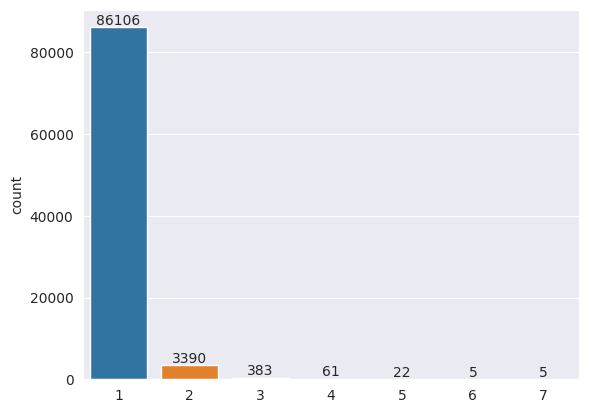

In [9]:
ax = sns.countplot(x=[len(x[2]) for y in train_list for x in y['sentences'] if x[0]])
ax.bar_label(ax.containers[0])
plt.show()

In [10]:
import re

def split_with_position(str_):
    word_pos_list = []
    for m in re.finditer(r'\S+', str_):
        pos, word = m.span(), m.group()
        word_pos_list.append((word, pos))
    return word_pos_list

In [11]:
def text_to_word_sequence(
    input_text,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    return_pos=True
):
    if lower:
        input_text = input_text.lower()

    translate_dict = {c: split for c in filters}
    translate_map = str.maketrans(translate_dict)
    input_text = input_text.translate(translate_map)

    if return_pos:
        return tuple(zip(*[(word, pos) for word, pos in split_with_position(input_text) if word]))
    else:
        return tuple(word for word, pos in split_with_position(input_text) if word)

In [12]:
text_to_word_sequence(" Ala ma kota! a")

(('ala', 'ma', 'kota', 'a'), ((1, 4), (5, 7), (8, 12), (14, 15)))

In [13]:
text_to_word_sequence(" Ala ma kota! a", return_pos=False)

('ala', 'ma', 'kota', 'a')

Histogram liczby słów w całych recenzjach:

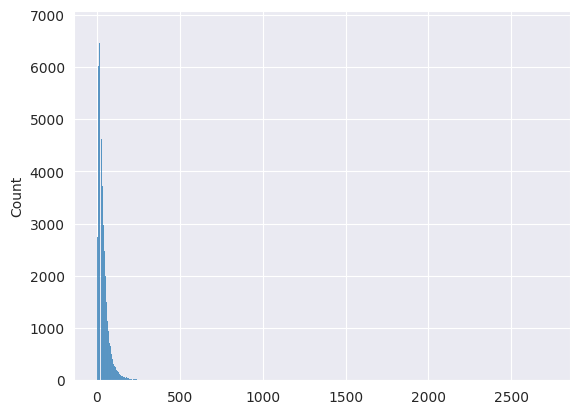

In [14]:
sns.histplot([len(text_to_word_sequence(' '.join(x[1] for x in y['sentences']), return_pos=False)) for y in train_list]);

Histogram liczby słów we zdaniach (wszystkich):

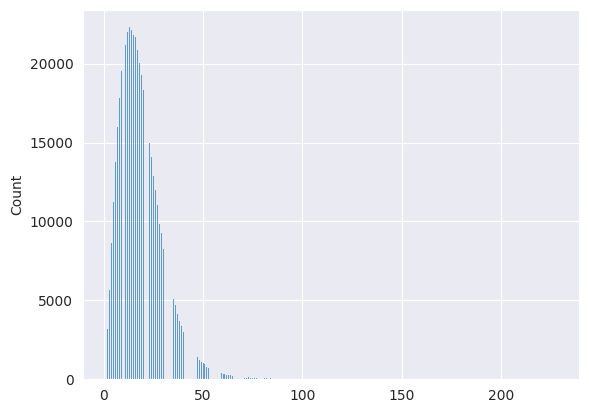

In [15]:
sns.histplot([len(text_to_word_sequence(x[1], return_pos=False)) for y in train_list for x in y['sentences']]);

Histogram liczby słów w zdaniach w tych recenzjach, które mają spoiler:

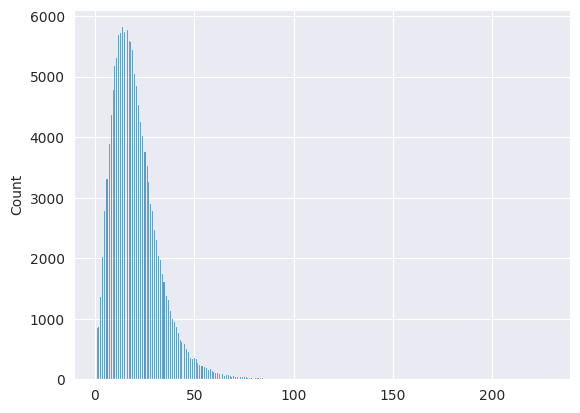

In [16]:
sns.histplot([len(text_to_word_sequence(x[1], return_pos=False)) for y in train_list for x in y['sentences'] if y['has_spoiler']]);

Histogram liczby słów w zdaniach ze spoilerami:

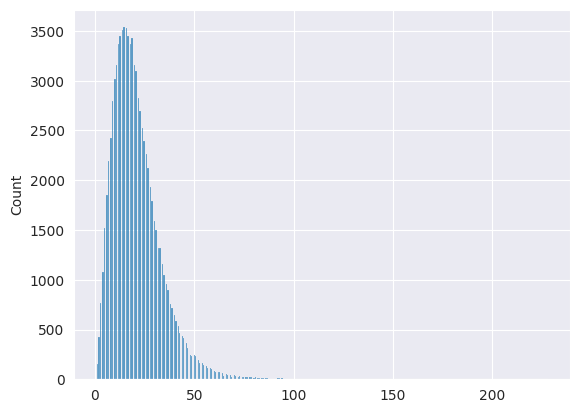

In [17]:
sns.histplot([len(text_to_word_sequence(x[1], return_pos=False)) for y in train_list for x in y['sentences'] if x[0]]);

Histogram gdzie się w zdaniu kończy spoiler (na którym słowie):

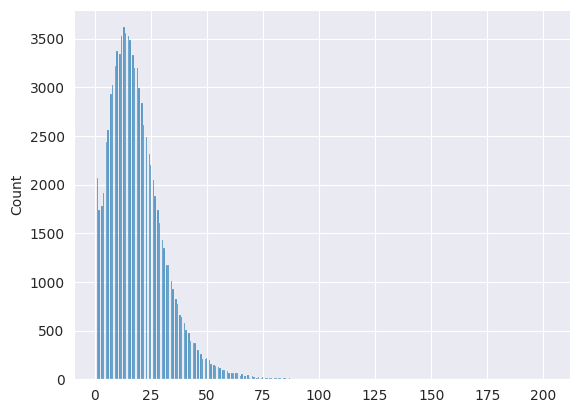

In [18]:
sns.histplot([len(text_to_word_sequence(x[1][:z[1]], return_pos=False)) for y in train_list for x in y['sentences'] if x[0] for z in x[2]]);

To, że powyższe wykresy są tak podobne sugeruje, że być może dużo zdań jest w całości zaanotowanych jako spoilery. Zatem jaki % zdania jest jak często zaanotowany jako spoiler (w zdaniach ze spoilerami)?

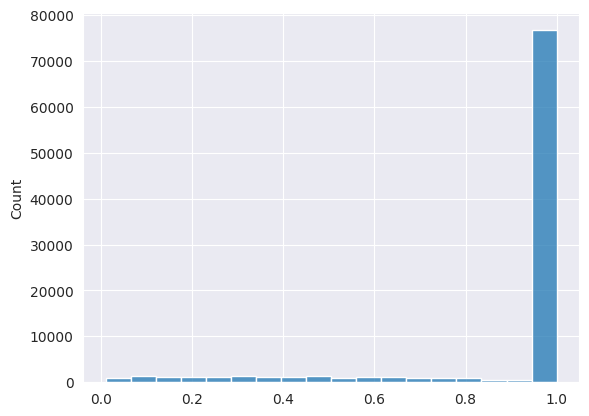

In [19]:
sns.histplot([len(text_to_word_sequence(x[1][:z[1]], return_pos=False)) / len(text_to_word_sequence(x[1], return_pos=False)) for y in train_list for x in y['sentences'] if x[0] for z in x[2]]);

Wniosek z EDA jest taki, że dużo zdań jest niestety zaanotowanych w całości. Zbiór, który stworzymy do eksperymentów zostanie zrobiony tak:

Bierzemy pod lupę jedną recenzję. Z niej wybeiramy zdania tak długo, póki mieścimy się w DIM tokenach. Zdania te rozkładamy na słowa, każde słowo dostaje label 0 (nie-spoiler) lub 1 (spoiler). W ten sposób, uzyskujemy fragmentu tekstu, o max DIM tokenach odpowiednio poanotowane.

In [20]:
DIM = 64

In [21]:
def in_range(interval_1, interval_2):
    assert interval_1[0] <= interval_1[1] and interval_2[0] <= interval_2[1]
    return interval_1[0] >= interval_2[0] and interval_1[1] <= interval_2[1]

In [22]:
def prepare_dataset(data_list):
    X_list = []
    y_list = []
    for data in data_list:
        if data["has_spoiler"]:
            sentence_data = data["sentences"]
            i = 0
            while i < len(sentence_data):
                # i points to the sentence to process
                input_words_list = []
                input_labels_list = []
                cur_words_count = 0

                while i < len(sentence_data):
                    next_sentence_words, next_sentence_word_positions = text_to_word_sequence(sentence_data[i][1])
                    if cur_words_count + len(next_sentence_words) > DIM:
                        if len(next_sentence_words) > DIM:
                            i += 1
                        break
                    cur_words_count += len(next_sentence_words)
                    input_words_list.extend(next_sentence_words)
                    input_labels_list.extend(any(in_range(pos, spoiler_boundary) for spoiler_boundary in sentence_data[i][2]) for pos in next_sentence_word_positions)
                    i += 1

                if input_words_list:
                    X_list.append(input_words_list)
                    y_list.append(input_labels_list)
    X_list = [" ".join(s) for s in X_list]
    return X_list, y_list

In [23]:
X_train_list, y_train_list = prepare_dataset(train_list)

In [24]:
X_train_list[4], y_train_list[4]

("celia is this to johnny because he's from a rich well to do family while she's white trash from sugar ditch and doesn't know how to cook clean and can't bear him children",
 [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True])

In [25]:
sum([1 for x in y_train_list if len(set(x)) >= 2])

47391

In [26]:
sum([1 for x in y_train_list if set(x) == {True}])

20416

In [27]:
sum([1 for x in y_train_list if set(x) == {False}])

12067

Mamy 47k zdań mieszanych, 20k zdań zawierających tylko słowa-spoilery i 12k zdań, w których nie ma ani jednego spoilera.

In [28]:
X_val_list, y_val_list = prepare_dataset(val_list)
X_test_list, y_test_list = prepare_dataset(test_list)

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
t = Tokenizer()
# Preprocessed_reviews contains all the cleaned reviews.
t.fit_on_texts(X_train_list)

In [30]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

86755


In [31]:
from tensorflow.keras.preprocessing import sequence

X_train = sequence.pad_sequences(t.texts_to_sequences(X_train_list), maxlen=DIM, padding='post')
y_train = sequence.pad_sequences(y_train_list, maxlen=DIM, padding='post')

X_val = sequence.pad_sequences(t.texts_to_sequences(X_val_list), maxlen=DIM, padding='post')
y_val = sequence.pad_sequences(y_val_list, maxlen=DIM, padding='post')

X_test = sequence.pad_sequences(t.texts_to_sequences(X_test_list), maxlen=DIM, padding='post')
y_test = sequence.pad_sequences(y_test_list, maxlen=DIM, padding='post')

In [32]:
import numpy as np
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    EMBEDDING_DIM = coefs.size

In [33]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((X_train.max()+1, EMBEDDING_DIM))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Bidirectional, TimeDistributed

Binary accuracy dziala dobrze, bo testowałem - PW

In [35]:
class JaccardSimilarity(tf.keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name)
        self.metric: tf.keras.metrics.Metric = tf.keras.metrics.IoU(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.greater(y_pred, 0.5)
        self.metric.update_state(y_true, y_pred)

    def reset_state(self):
        self.metric.reset_state()

    def result(self):
        return self.metric.result()

In [36]:
##LSTM
##fixing numpy RS
np.random.seed(0)
##fixing tensorflow RS
tf.random.set_seed(1)

HIDDEN_DIM= 256

inputs = Input(shape=(DIM, ), dtype='float32')
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], trainable = False)
encoder_LSTM_1 = Bidirectional(LSTM(HIDDEN_DIM, return_sequences=True))

dense_layer_relu = TimeDistributed(Dense(DIM, activation='relu'))
dense_layer = TimeDistributed(Dense(1, activation='sigmoid'))

encoder_embedding = embedding_layer(inputs)
encoded_seq = encoder_LSTM_1(encoder_embedding)

outputs = dense_layer_relu(encoded_seq)
outputs = dense_layer(outputs)

model = Model(inputs, outputs)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=[
                  'binary_accuracy',
                  JaccardSimilarity('jaccard_nonspoilers', num_classes=2, target_class_ids=[0]),
                  JaccardSimilarity('jaccard_spoilers', num_classes=2, target_class_ids=[1]),
                  JaccardSimilarity('mean_jaccard', num_classes=2, target_class_ids=[0, 1])
              ])
model.summary()

2023-01-04 23:35:13.039750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:35:13.053468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:35:13.053621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:35:13.054616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding (Embedding)       (None, 64, 100)           8675500   
                                                                 
 bidirectional (Bidirectiona  (None, 64, 512)          731136    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 64, 64)           32832     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 64, 1)            65        
 tributed)                                                       
                                                             

In [37]:
checkpoint_name = f"./checkpoints/lstm-best-val"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_name,
    save_weights_only=True,
    monitor="val_binary_accuracy",
    mode="max",
    save_best_only=True,
)

model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[model_checkpoint_callback])

Epoch 1/10


2023-01-04 23:35:16.173603: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


   6/2497 [..............................] - ETA: 27s - loss: 0.6640 - binary_accuracy: 0.6514 - jaccard_nonspoilers: 0.6173 - jaccard_spoilers: 0.2033 - mean_jaccard: 0.4103    

2023-01-04 23:35:16.685146: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2497/2497 [==============================] - 36s 13ms/step - loss: 0.3547 - binary_accuracy: 0.8016 - jaccard_nonspoilers: 0.7632 - jaccard_spoilers: 0.4493 - mean_jaccard: 0.6063 - val_loss: 0.3582 - val_binary_accuracy: 0.8141 - val_jaccard_nonspoilers: 0.7800 - val_jaccard_spoilers: 0.4543 - val_mean_jaccard: 0.6172
Epoch 2/10
2497/2497 [==============================] - 32s 13ms/step - loss: 0.3403 - binary_accuracy: 0.8153 - jaccard_nonspoilers: 0.7778 - jaccard_spoilers: 0.4780 - mean_jaccard: 0.6279 - val_loss: 0.3587 - val_binary_accuracy: 0.8169 - val_jaccard_nonspoilers: 0.7755 - val_jaccard_spoilers: 0.5020 - val_mean_jaccard: 0.6387
Epoch 3/10
2497/2497 [==============================] - 32s 13ms/step - loss: 0.3325 - binary_accuracy: 0.8227 - jaccard_nonspoilers: 0.7857 - jaccard_spoilers: 0.4931 - mean_jaccard: 0.6394 - val_loss: 0.3556 - val_binary_accuracy: 0.8183 - val_jaccard_nonspoilers: 0.7763 - val_jaccard_spoilers: 0.5085 - val_mean_jaccard: 0.6424
Epoch 4/10
2497

In [39]:
model.load_weights(checkpoint_name)
model.evaluate(X_test, y_test)

314/314 [==============================] - 2s 7ms/step - loss: 0.3630 - binary_accuracy: 0.8169 - jaccard_nonspoilers: 0.7811 - jaccard_spoilers: 0.4718 - mean_jaccard: 0.6264


[0.3630236089229584,
 0.8168897032737732,
 0.7810915112495422,
 0.47175756096839905,
 0.6264245510101318]